# EvoGFuzz: An Evolutionary Approach to Grammar-Based Fuzzing

**EvoGFuzz** stands for *evolutionary grammar-based fuzzing*. This approach leverages evolutionary optimization techniques to systematically explore the space of a program's potential inputs, with a particular emphasis on identifying inputs that could lead to exceptional behavior. With a user-defined objective, EvoGFuzz can adapt and refine the input generation strategy over time, making it a powerful tool for uncovering software defects and vulnerabilities.

Efficient detection of defects and vulnerabilities hinges on the ability to automatically generate program inputs that are both valid and diverse. One common strategy is to use grammars, which provide structured and syntactically correct inputs. This approach leads to the concept of grammar-based fuzzing, where fuzzing strategies are guided by the rules defined within the grammar.

A further enhancement to this concept is probabilistic grammar-based fuzzing, where competing grammar rules are associated with probabilities that guide their application. By carefully assigning and optimizing these probabilities, we gain considerable control over the nature of the generated inputs. This enables us to direct the fuzzing process towards specific areas of interest—for example, those functions that are deemed critical, have a higher propensity for failures, or have undergone recent modifications. 

In essence, EvoGFuzz represents a potent blend of evolutionary optimization and probabilistic grammar-based fuzzing, poised to reveal hidden defects and vulnerabilities in a targeted and efficient manner.

## Fuzzing a Program

Our program under investigation is `The Calculator`. This program acts as a typical calculator, capable of evaluating not just arithmetic expressions but also trigonometric functions, such as sine, cosine, and tangent. Furthermore, it also supports the calculation of the square root of a given number.

In [1]:
import math

def calculator(inp: str) -> float:
    """
        A simple calculator function that can evaluate arithmetic expressions 
        and perform basic trigonometric functions and square root calculations.
    """
    return eval(
        str(inp), {"sqrt": math.sqrt, "sin": math.sin, "cos": math.cos, "tan": math.tan}
    )

**Side Note:** In the `calculator`, we use Python's `eval` function, which takes a string and evaluates it as a Python expression. We provide a dictionary as the second argument to eval, mapping names to corresponding mathematical functions. This enables us to use the function names directly within the input string. 

In [2]:
# Evaluating the cosine of 2π
print(calculator('cos(6*3.141)'))

0.999993677717667


In [3]:
# Calculating the square root of 36
print(calculator('sqrt(6*6)'))

6.0


Each of these calls to the calculator will evaluate the provided string as a mathematical expression, and print the result.

Now, to find new defects, we need to introduce an oracle that tells us if the error that is triggered is something we expect or a new/unkonwn defect. The `OracleResult` is an enum with two possible values, `NO_BUG` and `BUG`. `NO_BUG` donates a passing test case and `BUG` a failing one.

We import the `OracleResult` enumerated type from the `evogfuzz` library. This is used in the oracle function to indicate the outcome of executing the 'calculator' function with a given input.

In [4]:
from evogfuzz.oracle import OracleResult

This is a function called **oracle**, which acts as an intermediary to handle and classify exceptions produced by the calculator function when given a certain input.

In [5]:
# Make sure you use the OracleResult from the evogfuzz library
from evogfuzz.oracle import OracleResult

def oracle(inp: str):
    """
    This function serves as an oracle or intermediary that catches and handles exceptions 
    generated by the 'calculator' function. The oracle function is used in the context of fuzz testing.
    It aims to determine whether an input triggers a bug in the 'calculator' function.

    Args:
        inp (str): The input string to be passed to the 'calculator' function.

    Returns:
        OracleResult: An enumerated type 'OracleResult' indicating the outcome of the function execution.
            - OracleResult.NO_BUG: Returned if the calculator function executes without any exception or only with CalculatorSyntaxError
            - OracleResult.BUG: Returned if the calculator function raises a ValueError exception, indicating a potential bug.
    """
    try:
        calculator(inp)
    except ValueError as e:
        return OracleResult.BUG
    
    return OracleResult.NO_BUG

This **oracle** function is used in the context of fuzzing to determine the impact of various inputs on the program under test (in our case the _calculator_). When the calculator function behaves as expected (i.e., no exceptions occur), the **oracle** function returns `OracleResult.NO_BUG`. However, when the `calculator` function raises an unexpected exception, the **oracle** interprets this as a potential bug in the `calculator` and returns `OracleResult.BUG`.

We can see this in action by testing a few initial inputs:

In [6]:
initial_inputs = ['sqrt(1)', 'cos(912)', 'tan(4)']

for inp in initial_inputs:
    print(inp.ljust(20), oracle(inp))

sqrt(1)              NO_BUG
cos(912)             NO_BUG
tan(4)               NO_BUG


The following code represents a simple context-free grammar for our calculator function. This grammar encompasses all the potential valid inputs to the calculator, which include mathematical expressions involving square roots, trigonometric functions, and integer and decimal numbers:

In [7]:
from fuzzingbook.Grammars import Grammar, is_valid_grammar

CALCGRAMMAR: Grammar = {
    "<start>":
        ["<function>(<term>)"],

    "<function>":
        ["sqrt", "tan", "cos", "sin"],
    
    "<term>": ["-<value>", "<value>"], 
    
    "<value>":
        ["<integer>.<integer>",
         "<integer>"],

    "<integer>":
        ["<digit><integer>", "<digit>"],

    "<digit>":
        ["1", "2", "3", "4", "5", "6", "7", "8", "9"]
}
    
grammar_alhazen: Grammar = {
    "<start>": ["<arith_expr>"],
    "<arith_expr>": ["<function>(<number>)"],
    "<function>": ["sqrt", "sin", "cos", "tan"],
    "<number>": ["<maybe_minus><onenine><maybe_digits><maybe_frac>"],
    "<maybe_minus>": ["", "-"],
    "<onenine>": [str(num) for num in range(1, 10)],
    "<digit>": [str(num) for num in range(0, 10)],
    "<maybe_digits>": ["", "<digits>"],
    "<digits>": ["<digit>", "<digit><digits>"],
    "<maybe_frac>": ["", ".<digits>"],
}
    
assert is_valid_grammar(grammar_alhazen)

The defined grammar CALCGRAMMAR provides a structured blueprint for creating various inputs for our fuzz testing. Each rule in this grammar reflects a possible valid input that our calculator function can handle. By fuzzing based on this grammar, we can systematically explore the space of valid inputs to the calculator function.

### Leveraging EvoGFuzz to Unearth New Defects

We apply our `EvoGFuzz` class to carry out fuzz testing using evolutionary grammar-based fuzzing. This is aimed at uncovering potential defects in our 'calculator' function.

To initialize our EvoGFuzz instance, we require a grammar (in our case, `CALCGRAMMAR`), an oracle function, an initial set of inputs, a fitness function, and the number of iterations to be performed in the fuzzing process.

Upon creating the `EvoGFuzz` instance, we can execute the fuzzing process. The `fuzz()` method runs the fuzzing iterations, evolving the inputs based on our fitness function, and returns a collection of inputs that lead to exceptions in the 'calculator' function.

In [8]:
from evogfuzz.evogfuzz_class import EvoGFuzz
from evogfuzz.helper import Tournament_Selection_Mode
import statistics

levenshtein_list=[]

while len(levenshtein_list)!=30:
    try:
        epp = EvoGFuzz(
            grammar=CALCGRAMMAR,
            oracle=oracle,
            inputs=initial_inputs,
            iterations=10,
            tournament_selection_mode = Tournament_Selection_Mode.HIERARCHICAL_LEVENSHTEIN
        )

        found_exception_inputs = epp.fuzz()
        
        levenshtein_list.append(len(found_exception_inputs))
        print(len(levenshtein_list),f"EvoGFuzz found {len(found_exception_inputs)} bug-triggering inputs!")
    except Exception as eee:
        print(eee)
statistics.mean(levenshtein_list)

1 EvoGFuzz found 236 bug-triggering inputs!
2 EvoGFuzz found 249 bug-triggering inputs!
3 EvoGFuzz found 260 bug-triggering inputs!
4 EvoGFuzz found 228 bug-triggering inputs!
5 EvoGFuzz found 295 bug-triggering inputs!
6 EvoGFuzz found 283 bug-triggering inputs!
7 EvoGFuzz found 209 bug-triggering inputs!
8 EvoGFuzz found 297 bug-triggering inputs!
9 EvoGFuzz found 281 bug-triggering inputs!
10 EvoGFuzz found 333 bug-triggering inputs!
11 EvoGFuzz found 224 bug-triggering inputs!
12 EvoGFuzz found 216 bug-triggering inputs!
13 EvoGFuzz found 295 bug-triggering inputs!
14 EvoGFuzz found 244 bug-triggering inputs!
15 EvoGFuzz found 171 bug-triggering inputs!
16 EvoGFuzz found 250 bug-triggering inputs!
17 EvoGFuzz found 297 bug-triggering inputs!
18 EvoGFuzz found 344 bug-triggering inputs!
19 EvoGFuzz found 286 bug-triggering inputs!
20 EvoGFuzz found 243 bug-triggering inputs!
21 EvoGFuzz found 326 bug-triggering inputs!
22 EvoGFuzz found 222 bug-triggering inputs!
23 EvoGFuzz found 2

265.26666666666665

In [9]:
jaro_list=[]

while len(jaro_list)!=30:
    try:
        epp = EvoGFuzz(
            grammar=CALCGRAMMAR,
            oracle=oracle,
            inputs=initial_inputs,
            iterations=10,
            tournament_selection_mode = Tournament_Selection_Mode.HIERARCHICAL_JARO
        )
        found_exception_inputs = epp.fuzz()
        jaro_list.append(len(found_exception_inputs))
        print(len(jaro_list),f"EvoGFuzz found {len(found_exception_inputs)} bug-triggering inputs!")
    except Exception as eee:
        print(eee)
statistics.mean(jaro_list)

1 EvoGFuzz found 214 bug-triggering inputs!
2 EvoGFuzz found 175 bug-triggering inputs!
3 EvoGFuzz found 187 bug-triggering inputs!
4 EvoGFuzz found 317 bug-triggering inputs!
5 EvoGFuzz found 248 bug-triggering inputs!
6 EvoGFuzz found 320 bug-triggering inputs!
7 EvoGFuzz found 294 bug-triggering inputs!
8 EvoGFuzz found 152 bug-triggering inputs!
9 EvoGFuzz found 274 bug-triggering inputs!
10 EvoGFuzz found 310 bug-triggering inputs!
11 EvoGFuzz found 295 bug-triggering inputs!
12 EvoGFuzz found 322 bug-triggering inputs!
13 EvoGFuzz found 283 bug-triggering inputs!
14 EvoGFuzz found 242 bug-triggering inputs!
15 EvoGFuzz found 170 bug-triggering inputs!
16 EvoGFuzz found 249 bug-triggering inputs!
17 EvoGFuzz found 282 bug-triggering inputs!
18 EvoGFuzz found 206 bug-triggering inputs!
19 EvoGFuzz found 347 bug-triggering inputs!
20 EvoGFuzz found 129 bug-triggering inputs!
21 EvoGFuzz found 257 bug-triggering inputs!
22 EvoGFuzz found 197 bug-triggering inputs!
23 EvoGFuzz found 2

248.83333333333334

In [10]:
from evogfuzz.evogfuzz_class import EvoGFuzz
from evogfuzz.helper import Tournament_Selection_Mode
import statistics

cos_list = []
while len(cos_list)!=30:
    try:
        epp = EvoGFuzz(
            grammar=CALCGRAMMAR,
            oracle=oracle,
            inputs=initial_inputs,
            iterations=10,
            tournament_selection_mode = Tournament_Selection_Mode.HIERARCHICAL_FEATURE_COS
        )
        found_exception_inputs = epp.fuzz()
        
        cos_list.append(len(found_exception_inputs))
        print(len(cos_list),f"EvoGFuzz found {len(found_exception_inputs)} bug-triggering inputs!")
    except Exception as eee:
        print(eee)
statistics.mean(cos_list)

1 EvoGFuzz found 266 bug-triggering inputs!
2 EvoGFuzz found 275 bug-triggering inputs!
3 EvoGFuzz found 242 bug-triggering inputs!
4 EvoGFuzz found 227 bug-triggering inputs!
5 EvoGFuzz found 314 bug-triggering inputs!
6 EvoGFuzz found 241 bug-triggering inputs!
7 EvoGFuzz found 240 bug-triggering inputs!
8 EvoGFuzz found 203 bug-triggering inputs!
9 EvoGFuzz found 116 bug-triggering inputs!
10 EvoGFuzz found 204 bug-triggering inputs!
11 EvoGFuzz found 339 bug-triggering inputs!
12 EvoGFuzz found 237 bug-triggering inputs!
13 EvoGFuzz found 117 bug-triggering inputs!
14 EvoGFuzz found 237 bug-triggering inputs!
15 EvoGFuzz found 214 bug-triggering inputs!
16 EvoGFuzz found 287 bug-triggering inputs!
17 EvoGFuzz found 208 bug-triggering inputs!
18 EvoGFuzz found 257 bug-triggering inputs!
19 EvoGFuzz found 202 bug-triggering inputs!
20 EvoGFuzz found 141 bug-triggering inputs!
21 EvoGFuzz found 268 bug-triggering inputs!
22 EvoGFuzz found 166 bug-triggering inputs!
23 EvoGFuzz found 2

227.36666666666667

In [11]:
normal_list = []
while len(normal_list)!=30:
    try:
        epp = EvoGFuzz(
            grammar=CALCGRAMMAR,
            oracle=oracle,
            inputs=initial_inputs,
            iterations=10,
        )
        found_exception_inputs = epp.fuzz()
        
        normal_list.append(len(found_exception_inputs))
        print(len(normal_list),f"EvoGFuzz found {len(found_exception_inputs)} bug-triggering inputs!")
    except Exception as eee:
        print(eee)
statistics.mean(normal_list)

1 EvoGFuzz found 457 bug-triggering inputs!
2 EvoGFuzz found 343 bug-triggering inputs!
3 EvoGFuzz found 154 bug-triggering inputs!
4 EvoGFuzz found 211 bug-triggering inputs!
5 EvoGFuzz found 13 bug-triggering inputs!
6 EvoGFuzz found 123 bug-triggering inputs!
7 EvoGFuzz found 213 bug-triggering inputs!
8 EvoGFuzz found 280 bug-triggering inputs!
9 EvoGFuzz found 470 bug-triggering inputs!
10 EvoGFuzz found 0 bug-triggering inputs!
11 EvoGFuzz found 397 bug-triggering inputs!
12 EvoGFuzz found 85 bug-triggering inputs!
13 EvoGFuzz found 112 bug-triggering inputs!
14 EvoGFuzz found 116 bug-triggering inputs!
15 EvoGFuzz found 276 bug-triggering inputs!
16 EvoGFuzz found 0 bug-triggering inputs!
17 EvoGFuzz found 36 bug-triggering inputs!
18 EvoGFuzz found 153 bug-triggering inputs!
19 EvoGFuzz found 32 bug-triggering inputs!
20 EvoGFuzz found 173 bug-triggering inputs!
21 EvoGFuzz found 191 bug-triggering inputs!
22 EvoGFuzz found 178 bug-triggering inputs!
23 EvoGFuzz found 519 bug-t

183.76666666666668

In [12]:
levenshtein_list

[236,
 249,
 260,
 228,
 295,
 283,
 209,
 297,
 281,
 333,
 224,
 216,
 295,
 244,
 171,
 250,
 297,
 344,
 286,
 243,
 326,
 222,
 204,
 305,
 204,
 283,
 247,
 368,
 253,
 305]

In [13]:
jaro_list

[214,
 175,
 187,
 317,
 248,
 320,
 294,
 152,
 274,
 310,
 295,
 322,
 283,
 242,
 170,
 249,
 282,
 206,
 347,
 129,
 257,
 197,
 211,
 241,
 295,
 178,
 261,
 291,
 241,
 277]

In [14]:
cos_list

[266,
 275,
 242,
 227,
 314,
 241,
 240,
 203,
 116,
 204,
 339,
 237,
 117,
 237,
 214,
 287,
 208,
 257,
 202,
 141,
 268,
 166,
 203,
 223,
 196,
 260,
 267,
 200,
 241,
 230]

In [15]:
normal_list

[457,
 343,
 154,
 211,
 13,
 123,
 213,
 280,
 470,
 0,
 397,
 85,
 112,
 116,
 276,
 0,
 36,
 153,
 32,
 173,
 191,
 178,
 519,
 0,
 183,
 0,
 14,
 228,
 271,
 285]

In [16]:
from scipy.stats import mannwhitneyu
sample_bugcount_list = [levenshtein_list, jaro_list, cos_list, normal_list]
names = ["levenshtein_list", "jaro_list", "cos_list", "normal_list"]

i=0
for elem in sample_bugcount_list:
    j=0
    for elem2 in sample_bugcount_list:
        U1, p = mannwhitneyu(elem, elem2, method="exact")
        U2 = len(elem)*len(elem2) - U1
        #print(names[i],names[j],statistics.mean(elem)>statistics.mean(elem2),statistics.mean(elem),statistics.mean(elem2),p)
        if p < 0.05:
            print(names[i],names[j],statistics.mean(elem)>statistics.mean(elem2),statistics.mean(elem),statistics.mean(elem2),p)
        j+=1
    i+=1

levenshtein_list cos_list True 265.26666666666665 227.36666666666667 0.004105053737194172
levenshtein_list normal_list True 265.26666666666665 183.76666666666668 0.0012219244183043752
jaro_list normal_list True 248.83333333333334 183.76666666666668 0.008773903357445878
cos_list levenshtein_list False 227.36666666666667 265.26666666666665 0.004105053737194172
normal_list levenshtein_list False 183.76666666666668 265.26666666666665 0.0012219244183043752
normal_list jaro_list False 183.76666666666668 248.83333333333334 0.008773903357445878


<AxesSubplot: >

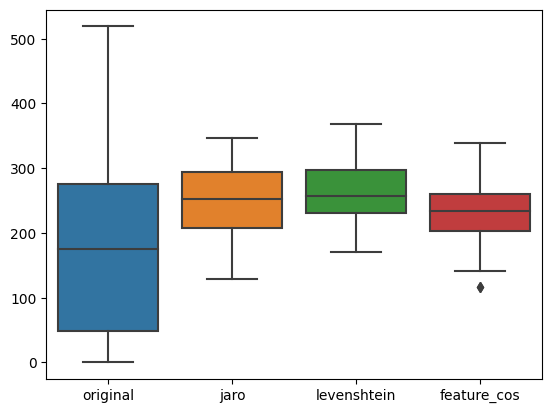

In [18]:
import seaborn as sns
import pandas as pd
sns.boxplot(data =  pd.DataFrame([normal_list, jaro_list, levenshtein_list, cos_list, ],
              index =["original", "jaro","levenshtein", "feature_cos", ]).T, )